In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
from model import load

In [3]:
import matplotlib.pyplot as plt

In [5]:
VALIDATION_SIZE = 5000
BATCH_SIZE, EPOCHS, ROUTING_ITERATIONS = 128, 100, 3
LAMBDA = 0.5
M_PLUS = 0.9
M_MINUS = 0.1
EPSILON = 1e-15
RECONSTRUCTION_LOSS_CONT = 5e-4 * 784
IMAGE_HEIGHT = IMAGE_WIDTH = 28
CONV_KERNEL_SIZE = 9
CONV_FILTERS = 256
CONV_STRIDE = 1
CAPSULE_STRIDE = 2
CAPSULE_KERNEL_SIZE = 9
CAPSULE_DIM = 8
CAPSULE_FILTERS = 32
CAPSULE_OUT_DIM = 16
CLASSES = 10
RECON_NET_1, RECON_NET_2, RECON_NET_3 = 512, 1024, IMAGE_HEIGHT * IMAGE_WIDTH

data = pd.read_csv('train.csv')

train_df = data.iloc[:, 1:].values
train_df = train_df.astype(np.float)

train_df = np.multiply(train_df, 1.0 / 255.0)

labels_flat = data.iloc[:, 0].values.ravel()


def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


labels = dense_to_one_hot(labels_flat, CLASSES)
labels = labels.astype(np.uint8)


validation_data = train_df[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_data = train_df[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

epochs_completed = 0
index_in_epoch = 0
num_examples = train_data.shape[0]


def next_batch(batch_size):
    global train_data
    global train_labels
    global index_in_epoch
    global epochs_completed

    start = index_in_epoch
    index_in_epoch += batch_size

    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_data = train_data[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_data[start:end], train_labels[start:end]


def squash(x, axis):
    sq_norm = tf.reduce_sum(tf.square(x), axis=axis, keep_dims=True)
    scalar_factor = sq_norm / (1 + sq_norm) / tf.sqrt(sq_norm + EPSILON)
    return tf.multiply(scalar_factor, x)


def placeholder(type, shape, name):
    return tf.placeholder(type, shape=shape, name=name)


def conv_layer(ip, filters, kernel_size, strides, name):
    return tf.layers.conv2d(ip, filters, kernel_size, strides, padding='VALID',
                            use_bias=True, bias_initializer=tf.zeros_initializer,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                            activation=tf.nn.relu, name=name)


X = placeholder(tf.float32, (None, IMAGE_WIDTH, IMAGE_HEIGHT, 1), 'X')
y = placeholder(tf.float32, (None, CLASSES), 'y')

with tf.variable_scope('conv1'):
    conv1 = conv_layer(X, CONV_FILTERS, CONV_KERNEL_SIZE, CONV_STRIDE, 'conv_layer')

with tf.variable_scope('prime_caps'):
    prime_caps = conv_layer(conv1, CAPSULE_DIM * CAPSULE_FILTERS, CAPSULE_KERNEL_SIZE,
                            CAPSULE_STRIDE, 'prime_caps')

    prime_caps = tf.reshape(prime_caps, shape=(BATCH_SIZE,
                                               6 * 6 * CAPSULE_FILTERS, 1,
                                               CAPSULE_DIM, 1))
    prime_caps = tf.tile(prime_caps, multiples=[1, 1, CLASSES, 1, 1])

    prime_caps = squash(prime_caps, axis=3)

W = tf.get_variable('W', dtype=tf.float32,
                    initializer=tf.random_normal_initializer(stddev=0.1),
                    shape=(1, 6 * 6 * CAPSULE_FILTERS,
                           CLASSES, CAPSULE_DIM, CAPSULE_OUT_DIM))

W = tf.tile(W, multiples=[BATCH_SIZE, 1, 1, 1, 1], name='tiledW')

with tf.variable_scope('capsule_to_digits'):
    u = tf.matmul(W, prime_caps, transpose_a=True)
    u = tf.reshape(tf.squeeze(u), (-1, 6 * 6 * CAPSULE_FILTERS,
                                   CAPSULE_OUT_DIM, CLASSES), name='u')

    b = tf.zeros((BATCH_SIZE, 6 * 6 * CAPSULE_FILTERS, CLASSES), dtype=tf.float32, name='b')

    for routing_iter in range(ROUTING_ITERATIONS):
        with tf.variable_scope('route_'+str(routing_iter)):
            c = tf.nn.softmax(b, dim=2)
            c = tf.reshape(c, shape=(BATCH_SIZE, 6 * 6 * CAPSULE_FILTERS, 1, CLASSES))

            s = tf.reduce_sum(u * c, axis=1, keep_dims=False)

            v = squash(s, axis=1)

            if routing_iter < ROUTING_ITERATIONS - 1:
                v_routed = tf.reshape(v, shape=(-1, 1, CAPSULE_OUT_DIM, CLASSES))

                uv = tf.reduce_sum(u * v_routed, axis=2, name='uv')

                b += uv

with tf.variable_scope('reconstruction_loss'):
    v_masked = tf.multiply(v, tf.reshape(y, (-1, 1, CLASSES)))
    v_masked = tf.reduce_sum(v_masked, axis=2, name='v_masked')

    layer1 = tf.layers.dense(v_masked, RECON_NET_1, activation=tf.nn.relu,
                             use_bias=True, kernel_initializer=tf.random_normal_initializer)
    layer2 = tf.layers.dense(layer1, RECON_NET_2, activation=tf.nn.relu,
                             use_bias=True, kernel_initializer=tf.random_normal_initializer)

    layer3 = tf.layers.dense(layer2, RECON_NET_3, activation=tf.nn.relu,
                             use_bias=True, kernel_initializer=tf.random_normal_initializer)

    reconstruction_loss = tf.reduce_mean(tf.square(layer3 - tf.reshape(X, (-1, 784))),
                                         name='reconstruction_loss')

In [6]:
sess = tf.InteractiveSession()

In [7]:
sess, _ = load(sess)

Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoints/CapsuleNet/CapsuleNet-0
Successfully read CapsuleNet-0


In [8]:
x_batch, y_batch = next_batch(BATCH_SIZE)
x_batch = x_batch.reshape((-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1))
rec = sess.run(layer3, feed_dict={X: x_batch, y: y_batch})

In [9]:
rec = rec.reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1))

In [20]:
sample = rec[10].reshape((IMAGE_WIDTH, IMAGE_HEIGHT))

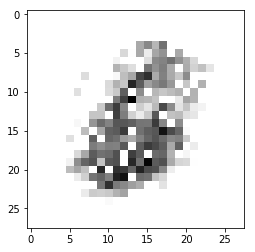

In [21]:
import matplotlib
plt.imshow(sample, cmap=matplotlib.cm.binary)
plt.show()

In [22]:
sample_act = x_batch[10].reshape((IMAGE_HEIGHT, IMAGE_WIDTH))

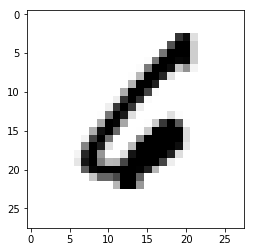

In [23]:
plt.imshow(sample_act, cmap=matplotlib.cm.binary)
plt.show()